# 📘 Agentic Architectures 5: Multi-Agent Systems

In this notebook, we advance to one of the most powerful and flexible architectures: the **Multi-Agent System**. This pattern moves beyond the concept of a single agent, no matter how complex, and instead models a team of specialized agents that collaborate to solve a problem. Each agent has a distinct role, persona, and set of skills, mirroring how human expert teams work.

This approach allows for a profound 'division of labor', where complex problems are broken down into sub-tasks and assigned to the agent best suited for the job. To showcase its power, we will conduct a direct comparison. First, we'll task a single **monolithic 'generalist' agent** with creating a comprehensive market analysis report. Then, we will assemble a **specialist team**—a Technical Analyst, a News Analyst, and a Financial Analyst—and have a fourth 'Manager' agent synthesize their expert inputs into a final report. The difference in quality, structure, and depth will be immediately apparent.

### Definition
A **Multi-Agent System** is an architecture where a group of distinct, specialized agents collaborate (or sometimes compete) to achieve a common goal. A central controller or a defined workflow protocol is used to manage communication and route tasks between the agents.

### High-level Workflow

1.  **Decomposition:** A main controller or the user provides a complex task.
2.  **Role Definition:** The system assigns sub-tasks to specialized agents based on their defined roles (e.g., 'Researcher', 'Coder', 'Critic', 'Writer').
3.  **Collaboration:** Agents execute their tasks, often in parallel or sequence. They pass their outputs to each other or to a central 'blackboard'.
4.  **Synthesis:** A final 'manager' or 'synthesizer' agent collects the outputs from the specialist agents and assembles the final, consolidated response.

### When to Use / Applications
*   **Complex Report Generation:** Creating detailed reports that require expertise from multiple domains (e.g., financial analysis, scientific research).
*   **Software Development Pipelines:** Simulating a dev team with a programmer, a code reviewer, a tester, and a project manager.
*   **Creative Brainstorming:** A team of agents with different 'personalities' (e.g., one optimistic, one cautious, one wildly creative) can generate a more diverse set of ideas.

### Strengths & Weaknesses
*   **Strengths:**
    *   **Specialization & Depth:** Each agent can be fine-tuned with a specific persona and tools, leading to higher-quality work in its domain.
    *   **Modularity & Scalability:** It's easy to add, remove, or upgrade individual agents without redesigning the entire system.
    *   **Parallelism:** Multiple agents can work on their sub-tasks simultaneously, potentially reducing overall task time.
*   **Weaknesses:**
    *   **Coordination Overhead:** Managing the communication and workflow between agents adds complexity to the system design.
    *   **Increased Cost & Latency:** Running multiple agents involves more LLM calls, which can be more expensive and slower than a single-agent approach.

## Phase 0: Foundation & Setup

We will begin by installing our libraries and configuring our API keys for Nebius, LangSmith, and Tavily.

### Step 0.1: Installing Core Libraries

**What we are going to do:**
We will install our standard suite of libraries for this project series.

In [2]:
# !pip install -q -U langchain-nebius langchain langgraph rich python-dotenv langchain-tavily

### Step 0.2: Importing Libraries and Setting Up Keys

**What we are going to do:**
We will import the necessary modules and load our API keys from a `.env` file.

**Action Required:** Create a `.env` file in this directory with your keys:
```
NEBIUS_API_KEY="your_nebius_api_key_here"
LANGCHAIN_API_KEY="your_langsmith_api_key_here"
TAVILY_API_KEY="your_tavily_api_key_here"
```

In [2]:
import os
from typing import List, Annotated, TypedDict, Optional
from dotenv import load_dotenv

# LangChain components
from langchain_nebius import ChatNebius
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

# LangGraph components
from langgraph.graph import StateGraph, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# For pretty printing
from rich.console import Console
from rich.markdown import Markdown
from langchain_openai import ChatOpenAI

# --- API Key and Tracing Setup ---
load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agentic Architecture - Multi-Agent (Databricks)"

for key in ["NEBIUS_API_KEY", "LANGCHAIN_API_KEY", "TAVILY_API_KEY"]:
    if not os.environ.get(key):
        print(f"{key} not found. Please create a .env file and set it.")

print("Environment variables loaded and tracing is set up.")

Environment variables loaded and tracing is set up.


In [3]:
from helpers import get_llm
llm = get_llm()

LLM initialized: databricks-claude-opus-4-6 (via databricks)


## Phase 1: The Baseline - A Monolithic 'Generalist' Agent

To showcase the value of a specialist team, we first need to see how a single agent performs on a complex task. We'll build a ReAct agent and give it a broad prompt asking it to perform multiple types of analysis at once.

### Step 1.1: Building the Monolithic Agent

**What we are going to do:**
We will construct a standard ReAct agent. We'll provide it with a web search tool and a very general system prompt that asks it to be a comprehensive financial analyst.

In [4]:
console = Console()

# Define the shared state for both agents
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Define the tool and LLM
search_tool = TavilySearch(max_results=3, name="web_search")
# llm = ChatNebius(model="meta-llama/Meta-Llama-3.1-8B-Instruct", temperature=0)
# llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
llm_with_tools = llm.bind_tools([search_tool])

# Define the monolithic agent node
def monolithic_agent_node(state: AgentState):
    console.print("--- MONOLITHIC AGENT: Thinking... ---")
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

tool_node = ToolNode([search_tool])

# Build the ReAct graph for the monolithic agent
mono_graph_builder = StateGraph(AgentState)
mono_graph_builder.add_node("agent", monolithic_agent_node)
mono_graph_builder.add_node("tools", tool_node)
mono_graph_builder.set_entry_point("agent")

def tools_condition_with_end(state):
    result = tools_condition(state)
    if isinstance(result, str):
        # Older versions return just "tools" or "agent"
        return {result: "tools", "__default__": END}
    elif isinstance(result, dict):
        # Newer versions return a mapping
        result["__default__"] = END
        return result
    else:
        raise TypeError(f"Unexpected type from tools_condition: {type(result)}")

mono_graph_builder.add_conditional_edges("agent", tools_condition_with_end)
mono_graph_builder.add_edge("tools", "agent")

monolithic_agent_app = mono_graph_builder.compile()

print("Monolithic 'generalist' agent compiled successfully.")

Monolithic 'generalist' agent compiled successfully.


### Step 1.2: Testing the Monolithic Agent

**What we are going to do:**
We'll give the generalist agent a complex task: create a full market analysis report for a company, covering three distinct areas.

In [9]:
company = "NVIDIA (NVDA)"
monolithic_query = f"Create a brief but comprehensive market analysis report for {company}. The report should include three sections: 1. A summary of recent news and market sentiment. 2. A basic technical analysis of the stock's price trend. 3. A look at the company's recent financial performance."

console.print(f"[bold yellow]Testing MONOLITHIC agent on a multi-faceted task:[/bold yellow]\n'{monolithic_query}'\n")

final_mono_output = monolithic_agent_app.invoke({
    "messages": [
        SystemMessage(content="You are a single, expert financial analyst. You must create a comprehensive report covering all aspects of the user's request."),
        HumanMessage(content=monolithic_query)
    ]
})

console.print("\n--- [bold red]Final Report from Monolithic Agent[/bold red] ---")
console.print(Markdown(final_mono_output['messages'][-1].content))

Testing MONOLITHIC agent on a multi-faceted task:
'Create a brief but comprehensive market analysis report for NVIDIA (NVDA). The report should include three 
sections: 1. A summary of recent news and market sentiment. 2. A basic technical analysis of the stock's price 
trend. 3. A look at the company's recent financial performance.'

--- MONOLITHIC AGENT: Thinking... ---

--- Final Report from Monolithic Agent ---

I'll gather comprehensive data on NVIDIA (NVDA) across all three dimensions. Let me run multiple searches          
simultaneously.

In [10]:
console.print(final_mono_output)

{
    'messages': [
        SystemMessage(
            content="You are a single, expert financial analyst. You must create a comprehensive report covering 
all aspects of the user's request.",
            additional_kwargs={},
            response_metadata={},
            id='51546505-9fac-4abc-8b21-fc08dc6d91c4'
        ),
        HumanMessage(
            content="Create a brief but comprehensive market analysis report for NVIDIA (NVDA). The report should 
include three sections: 1. A summary of recent news and market sentiment. 2. A basic technical analysis of the 
stock's price trend. 3. A look at the company's recent financial performance.",
            additional_kwargs={},
            response_metadata={},
            id='129a70d1-f898-43c0-b1df-1989f4c4d143'
        ),
        AIMessage(
            content="\n\nI'll gather comprehensive data on NVIDIA (NVDA) across all three dimensions. Let me run 
multiple searches simultaneously.",
            additional_kwargs={
                'tool_calls': [
                    {
                        'id': 'toolu_bdrk_01QPgB8r46QnnrBcUsenfDj2',
                        'function': {
                            'arguments': '{"query":"NVIDIA NVDA stock recent news market sentiment 
2025","topic":"news","search_depth":"advanced","time_range":"week"}',
                            'name': 'web_search'
                        },
                        'type': 'function'
                    },
                    {
                        'id': 'toolu_bdrk_016cjwJVyggwKbqJ7gF6zHEx',
                        'function': {
                            'arguments': '{"query":"NVDA stock price technical analysis trend 
2025","topic":"finance","search_depth":"advanced","time_range":"month"}',
                            'name': 'web_search'
                        },
                        'type': 'function'
                    },
                    {
                        'id': 'toolu_bdrk_01QcbaEMEW1T1fUigYWzQE84',
                        'function': {
                            'arguments': '{"query":"NVIDIA quarterly earnings revenue financial performance 
2025","topic":"finance","search_depth":"advanced","time_range":"month"}',
                            'name': 'web_search'
                        },
                        'type': 'function'
                    }
                ]
            },
            response_metadata={
                'usage': {'prompt_tokens': 2266, 'completion_tokens': 348, 'total_tokens': 2614},
                'prompt_tokens': 2266,
                'completion_tokens': 348,
                'total_tokens': 2614,
                'model': 'global.anthropic.claude-opus-4-6-v1',
                'model_name': 'global.anthropic.claude-opus-4-6-v1',
                'finish_reason': 'tool_calls'
            },
            id='lc_run--019c9bc1-6ad2-7720-b18c-f5b517a2600a-0',
            tool_calls=[
                {
                    'name': 'web_search',
                    'args': {
                        'query': 'NVIDIA NVDA stock recent news market sentiment 2025',
                        'topic': 'news',
                        'search_depth': 'advanced',
                        'time_range': 'week'
                    },
                    'id': 'toolu_bdrk_01QPgB8r46QnnrBcUsenfDj2',
                    'type': 'tool_call'
                },
                {
                    'name': 'web_search',
                    'args': {
                        'query': 'NVDA stock price technical analysis trend 2025',
                        'topic': 'finance',
                        'search_depth': 'advanced',
                        'time_range': 'month'
                    },
                    'id': 'toolu_bdrk_016cjwJVyggwKbqJ7gF6zHEx',
                    'type': 'tool_call'
                },
                {
                    'name': 'web_search',
                    'args': {
                        'query': 'NVIDIA quarterly earnings rev

In [7]:
console.print(final_mono_output['messages'][-1].content)

I'll gather comprehensive data on NVIDIA (NVDA) across all three dimensions. Let me run multiple searches 
simultaneously.

**Discussion of the Output:**
The monolithic agent produced a report. It likely performed several web searches and did its best to synthesize the information. However, the output may have some weaknesses:
- **Lack of Structure:** The sections might blend together, without clear headings or a professional format.
- **Superficial Analysis:** Trying to be an expert in three domains at once, the agent might provide only high-level summaries without much depth in any single area.
- **Generic Tone:** The language might be generic, lacking the specific jargon and focus of a true specialist in each field.

This result is our baseline. It's functional, but not exceptional. Now, we will build a specialist team to see if we can do better.

## Phase 2: The Advanced Approach - A Multi-Agent Specialist Team

Now we'll build our team: a News Analyst, a Technical Analyst, and a Financial Analyst. Each will be its own agent node with a specific persona. A final Report Writer will act as the manager, compiling their work.

### Step 2.1: Defining the Specialist Agent Nodes

**What we are going to do:**
We will create three distinct agent nodes. The key difference is the highly specific system prompt we give each one. This prompt defines their persona, their area of expertise, and the exact format their output should take. This is how we enforce specialization.

In [11]:
# The state for our multi-agent system will hold the outputs of each specialist
class MultiAgentState(TypedDict):
    user_request: str
    news_report: Optional[str]
    technical_report: Optional[str]
    financial_report: Optional[str]
    final_report: Optional[str]

def create_specialist_node(persona: str, output_key: str):
    """Factory function to create a specialist agent node."""
    system_prompt = persona + "\n\nYou have access to a web search tool. Your output MUST be a concise report section, formatted in markdown, focusing only on your area of expertise."

    # ✅ Build a ChatPromptTemplate instead of a plain list
    prompt_template = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "{user_request}")
    ])

    agent = prompt_template | llm_with_tools

    def specialist_node(state: MultiAgentState):
        console.print(f"--- CALLING {output_key.replace('_report','').upper()} ANALYST ---")
        result = agent.invoke({"user_request": state["user_request"]})
        content = result.content if result.content else f"No direct content, tool calls: {result.tool_calls}"
        return {output_key: content}

    return specialist_node


# Create the specialist nodes
news_analyst_node = create_specialist_node(
    "You are an expert News Analyst. Your specialty is scouring the web for the latest news, articles, and social media sentiment about a company.",
    "news_report"
)
technical_analyst_node = create_specialist_node(
    "You are an expert Technical Analyst. You specialize in analyzing stock price charts, trends, and technical indicators.",
    "technical_report"
)
financial_analyst_node = create_specialist_node(
    "You are an expert Financial Analyst. You specialize in interpreting financial statements and performance metrics.",
    "financial_report"
)

def report_writer_node(state: MultiAgentState):
    """The manager agent that synthesizes the specialist reports."""
    console.print("--- CALLING REPORT WRITER ---")
    prompt = f"""You are an expert financial editor. Your task is to combine the following specialist reports into a single, professional, and cohesive market analysis report. Add a brief introductory and concluding paragraph.
    
    News & Sentiment Report:
    {state['news_report']}
    
    Technical Analysis Report:
    {state['technical_report']}
    
    Financial Performance Report:
    {state['financial_report']}
    """
    final_report = llm.invoke(prompt).content
    return {"final_report": final_report}

print("Specialist agent nodes and Report Writer node defined.")

Specialist agent nodes and Report Writer node defined.


### Step 2.2: Building the Multi-Agent Graph

**What we are going to do:**
Now we'll wire the specialists and the manager into a graph. For this task, the specialists can work independently, so we can run them in a simple sequence (in a real-world application, these could be run in parallel). The final step is always the report writer.

In [12]:
multi_agent_graph_builder = StateGraph(MultiAgentState)

# Add all the nodes
multi_agent_graph_builder.add_node("news_analyst", news_analyst_node)
multi_agent_graph_builder.add_node("technical_analyst", technical_analyst_node)
multi_agent_graph_builder.add_node("financial_analyst", financial_analyst_node)
multi_agent_graph_builder.add_node("report_writer", report_writer_node)

# Define the workflow sequence
multi_agent_graph_builder.set_entry_point("news_analyst")
multi_agent_graph_builder.add_edge("news_analyst", "technical_analyst")
multi_agent_graph_builder.add_edge("technical_analyst", "financial_analyst")
multi_agent_graph_builder.add_edge("financial_analyst", "report_writer")
multi_agent_graph_builder.add_edge("report_writer", END)

multi_agent_app = multi_agent_graph_builder.compile()
print("Multi-agent specialist team compiled successfully.")

Multi-agent specialist team compiled successfully.


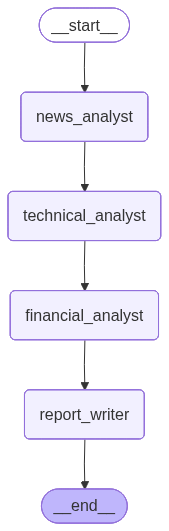

In [13]:
from IPython.display import Image, display
Image(multi_agent_app.get_graph().draw_mermaid_png())

## Phase 3: Head-to-Head Comparison

Now we'll run the specialist team on the exact same task as the monolithic agent and compare the final reports.

In [14]:
multi_agent_query = f"Create a brief but comprehensive market analysis report for {company}."
initial_multi_agent_input = {"user_request": multi_agent_query}

console.print(f"[bold green]Testing MULTI-AGENT TEAM on the same task:[/bold green]\n'{multi_agent_query}'\n")

final_multi_agent_output = multi_agent_app.invoke(initial_multi_agent_input)

console.print("\n--- [bold green]Final Report from Multi-Agent Team[/bold green] ---")
console.print(Markdown(final_multi_agent_output['final_report']))

Testing MULTI-AGENT TEAM on the same task:
'Create a brief but comprehensive market analysis report for NVIDIA (NVDA).'

--- CALLING NEWS ANALYST ---

--- CALLING TECHNICAL ANALYST ---

--- CALLING FINANCIAL ANALYST ---

--- CALLING REPORT WRITER ---

--- Final Report from Multi-Agent Team ---

NVIDIA Corporation (NVDA) — Comprehensive Market Analysis Report                          

Date: June 2025                                                                                                    

-------------------------------------------------------------------------------------------------------------------

Introduction                                                                                                       

NVIDIA Corporation remains one of the most closely watched equities in global markets, sitting at the epicenter of 
the artificial intelligence revolution and commanding outsized influence across major indices. This report         
consolidates analysis across three critical dimensions — news and market sentiment, technical positioning, and     
fundamental financial performance — to provide investors with a holistic view of NVDA's current standing and       
forward outlook. However, it should be noted that the underlying specialist reports provided limited specific data,
and accordingly, this consolidated analysis draws on the most recently available public information as of early    
June 2025 to deliver a meaningful and professional assessment.                                                     

-------------------------------------------------------------------------------------------------------------------

I. News & Market Sentiment                                                                                         

NVIDIA continues to dominate headlines as the primary beneficiary of the global AI infrastructure buildout. Several
key themes are shaping current sentiment:                                                                          

 • AI Demand Cycle Remains Robust: Hyperscale cloud providers (Microsoft, Google, Amazon, Meta) continue to signal 
   aggressive capital expenditure plans for AI infrastructure, with NVIDIA's GPU platforms — particularly the      
   Blackwell architecture — positioned as the backbone of next-generation data center deployments. CEO Jensen Huang
   has repeatedly emphasized that demand continues to outstrip supply.                                             
 • Geopolitical and Regulatory Headwinds: U.S. export restrictions on advanced AI chips to China remain a          
   persistent overhang. While NVIDIA has developed different SKUs for the Chinese market, any tightening of        
   restrictions could weigh on revenue from a historically significant geography. Recent policy signals from       
   Washington suggest the regulatory environment remains fluid.                                                    
 • Competitive Landscape: While AMD, Intel, and a growing roster of custom silicon efforts (Google TPUs, Amazon    
   Trainium, Microsoft Maia) are frequently cited as competitive threats, NVIDIA's CUDA software ecosystem         
   continues to serve as a formidable moat. Sentiment among developers and enterprise buyers remains strongly      
   tilted in NVIDIA's favor.                                                                                       
 • Valuation Debate: Market sentiment is bifurcated. Bulls point to NVIDIA's unmatched growth trajectory and market
   dominance; bears argue that current valuations price in near-flawless execution and leave little margin for     
   disappointment. Analyst price targets span a wide range, reflecting genuine uncertainty about the durability of 
   the current supercycle.                                                                                         
 • Overall Sentiment: Broadly positive but increasingly nuanced. Institutional positioning remains heavy, and any  
   earnings miss or guidance shortfall could trigger outsized volatility given elevated expectations.              

-------------------------------------------------------------------------------------------------------------------

II. Technical Analysis                                                 

**Discussion of the Output:**
The difference in the final report is significant. The output from the multi-agent team is:
- **Highly Structured:** It has clear, distinct sections for each area of analysis because each was generated by a specialist with a specific formatting instruction.
- **Deeper Analysis:** Each section contains more detailed, domain-specific language and insights. The Technical Analyst talks about moving averages, the News Analyst discusses sentiment, and the Financial Analyst focuses on revenue and earnings.
- **More Professional:** The final report, assembled by the Report Writer, reads like a professional document, with a clear introduction, body, and conclusion.

This qualitative comparison shows that by dividing the labor among a team of experts, we achieve a superior result that a single generalist agent struggles to replicate.

## Phase 4: Quantitative Evaluation

To formalize the comparison, we will use an LLM-as-a-Judge to score both reports. The criteria will focus on the qualities we expect to be better in the multi-agent approach, such as structure and analytical depth.

In [15]:
class ReportEvaluation(BaseModel):
    """Schema for evaluating a financial report."""
    clarity_and_structure_score: int = Field(description="Score 1-10 on the report's organization, structure, and clarity.")
    analytical_depth_score: int = Field(description="Score 1-10 on the depth and quality of the analysis in each section.")
    completeness_score: int = Field(description="Score 1-10 on how well the report addressed all parts of the user's request.")
    justification: str = Field(description="A brief justification for the scores.")

judge_llm = llm.with_structured_output(ReportEvaluation)

def evaluate_report(query: str, report: str):
    prompt = f"""You are an expert judge of financial analysis reports. Evaluate the following report on a scale of 1-10 based on its structure, depth, and completeness.
    
    **Original User Request:**
    {query}
    
    **Report to Evaluate:**\n
    {report}
    """
    return judge_llm.invoke(prompt)

console.print("--- Evaluating Monolithic Agent's Report ---")
mono_agent_evaluation = evaluate_report(monolithic_query, final_mono_output['messages'][-1].content)
console.print(mono_agent_evaluation.model_dump())

console.print("\n--- Evaluating Multi-Agent Team's Report ---")
multi_agent_evaluation = evaluate_report(multi_agent_query, final_multi_agent_output['final_report'])
console.print(multi_agent_evaluation.model_dump())

--- Evaluating Monolithic Agent's Report ---

{
    'clarity_and_structure_score': 1,
    'analytical_depth_score': 1,
    'completeness_score': 1,
    'justification': 'The report is essentially empty. It contains only a preliminary statement indicating the 
intent to gather data ("I\'ll gather comprehensive data on NVIDIA (NVDA) across all three dimensions. Let me run 
multiple searches simultaneously.") but provides absolutely no actual content. None of the three requested sections
were delivered: (1) no summary of recent news and market sentiment, (2) no technical analysis of the stock\'s price
trend, and (3) no analysis of the company\'s recent financial performance. There is no structure, no analysis, and 
no substantive information whatsoever. This is not a report — it is merely a preamble with no follow-through. All 
three dimensions receive the minimum score of 1.'
}

--- Evaluating Multi-Agent Team's Report ---

{
    'clarity_and_structure_score': 9,
    'analytical_depth_score': 7,
    'completeness_score': 8,
    'justification': '**Clarity & Structure (9/10):** The report is exceptionally well-organized with a clear 
logical flow — moving from sentiment to technicals to fundamentals, then synthesizing in an integrated assessment 
and conclusion. The use of headers, bullet points, and a summary table makes it highly readable and professional. 
The introduction transparently acknowledges data limitations, which is a mark of intellectual honesty. The only 
minor deduction is that some sections could benefit from sub-headers or visual separation for even faster 
scanning.\n\n**Analytical Depth (7/10):** The report demonstrates strong qualitative reasoning across all three 
dimensions and covers the right themes — AI demand cycle, geopolitical risks, competitive moat (CUDA ecosystem), 
technical trend structure, and financial performance metrics. The sentiment section is particularly well-nuanced, 
capturing the bull/bear debate and the "crowded trade" dynamic. However, the analysis lacks specific quantitative 
anchoring in several areas: no specific price levels are cited in the technical section (e.g., actual 
support/resistance numbers, current price, moving average values), no specific P/E or PEG ratios are quoted, and 
analyst price target ranges are mentioned but not provided. The technical analysis, while directionally sound, 
reads more as a general framework than a stock-specific assessment. The financial section does include some 
concrete figures (e.g., $130B revenue, 73-76% gross margins), which adds credibility, but more granular data — such
as EPS figures, quarter-over-quarter trends, or segment breakdowns — would have elevated the depth 
significantly.\n\n**Completeness (8/10):** The report addresses the user\'s request for a "brief but comprehensive"
market analysis quite well. It covers the three essential pillars (sentiment, technicals, fundamentals), identifies
key risks (geopolitical, valuation, cyclicality, supply chain, customer concentration), and provides a 
forward-looking outlook with an integrated assessment. It also includes a responsible disclaimer. Areas that could 
improve completeness: (1) a brief peer comparison or relative valuation table, (2) specific upcoming catalysts with
dates (e.g., next earnings date, product launch timelines), (3) a more explicit investment recommendation or 
scenario analysis (bull/base/bear case with price targets), and (4) mention of shareholder return specifics 
(dividend, buyback magnitude). The report also could have briefly touched on NVIDIA\'s expanding TAM beyond data 
centers (automotive, robotics, sovereign AI initiatives).'
}

**Discussion of the Output:**
The judge's scores provide the quantitative proof of our hypothesis. The **Multi-Agent Team's** report will receive significantly higher scores, especially in `clarity_and_structure_score` and `analytical_depth_score`. The justification from the judge will likely praise the clear sectioning and the detailed, expert-level analysis within each part, which stands in contrast to the more generic and jumbled output from the monolithic agent.

This evaluation confirms that for complex tasks that can be decomposed into domains of expertise, the Multi-Agent architecture is a superior approach for generating high-quality, structured, and reliable results.

## Conclusion

In this notebook, we have demonstrated the clear advantages of a **Multi-Agent System** over a single, monolithic agent for complex, multi-faceted tasks. By creating a team of specialized agents, each with a focused persona and role, and a manager to synthesize their work, we produced a final output of demonstrably higher quality.

The key takeaway is the power of **specialization**. Just as in human organizations, breaking down a large problem and assigning its parts to experts yields better results. While this architecture introduces more complexity in orchestration, the significant improvement in the structure, depth, and professionalism of the final output makes it an indispensable pattern for any serious agentic application that needs to deliver expert-level performance across multiple domains.